# Lending Club - Case Study

### Import and Prep the data

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Reading the input data (csv)

In [2]:
loan = pd.read_csv('loan.csv', header=0)

loan.shape

(39717, 111)

#### Initial Analysis

- The Data contains 38717 Records and 111 rows. 
- The data contains many columns which have only 1 unique value in the entire dataset. These columns may not be useful..

In [3]:
### Columns that have only 1 value in the dataset. They doesn't help us in the analysis and can be ignored.
for col in loan.columns:
    if(len(loan[col].unique()) == 1) :
        print(col)

columns_to_work = loan.columns[loan.apply(lambda x: len(x.unique()) > 1)].tolist()
loan = loan.loc[:, columns_to_work]
loan.info()

# to verify if the changes are implied.
# loan.columns[loan.apply(lambda x: len(x.unique()) == 1)]

pymnt_plan
initial_list_status
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 t

- The requested Loan Amount is listed in the column **loan_amnt**
- The Loan amount suggested by the Lending Club at the time of loan issuance is listed in the column **funded_amnt**
- The Loan approved by the investor authority (final loan amount is mentioned in the **funded_amnt_inv**)
- The column **term** represents the tenure of the Loan. We have only 2 values here 36 months and 60 months. - *TODO:* clean the data to make it an integer.
- The loan issue date is represented in the column **issue_d**. It has missing day column. - *TODO:* Convert this to a DateTime and extract the year and month details. 
- The interest rate of the loan approved is mentioned in the **int_rate** column - *TODO:* Clean the data by removing the % so as we can use it for bucketted analysis.
- The **installment** column represents the monthly installments to be paid against the loan.
- The **grade** and **sub-grade** are the internal categories assigned by the Lending Club. May be used to differentiate certain entries. 

- The column **emp_title** has incomplete information. However, if we can filter down the empty values, we may observe a patten.
- The column **emp_length** has inadequate data;

- The column **home_ownership** is an important attribute and can be analyzed to identify a correlation across the defaulters.
- The column **annual_inc** has annual incomes and can be used for analysis to identify how it is impacting the defaulters.
- The column **verification_status** has background verification status; an important attribute which can identify the defaulters.
- The column **issue_d** is the loan issued date. We can extract the information of month and year from it. 
- The column **loan_status** signifies if the loan is fully paid/current/charged off. It may not make any sense to analyze the loans in current status. Hence, we can filter it out and compare the rest. 
- The column **pymnt_plan** has unique value 'n' across the data set; Hence it can be ignored. 
- The column **url**, desc are not useful for our current analysis; Hence, can be ignored. 
- The column **purpose** serves as an good categorical variable for our analysis.
- The column **title** may be a title of the loan application and may not be a good candidate for analysis.
- The column **zip_code**, state may be used to extract the impact demographics over the possibility of defaulting.
- The column **dti** - Debit to Income, could be an important factor as it determines the economic potential of the member.
- The column **pub_rec_bankruptcies** may help us identify the previous bankruptcies.


#### Check if any columns are null or has invalid data

In [4]:
loan.columns.isnull().any()

False

In [5]:
loan.columns.isna().any()

False

In [6]:
# Convert term data to numeric

loan['term'] = loan.term.apply(lambda x: int(x.replace(' months','')))
# loan.term.head()

# Convert the Interest Rate Column
loan['int_rate'] = loan.int_rate.apply(lambda x: float(x.replace('%', '')))
# loan.int_rate.head()

# loan.head()

In [7]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  int64  
 6   int_rate                    39717 non-null  float64
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [8]:
#from datetime import datetime
#loan.issue_d.apply(lambda x: datetime.strptime(x, '%b-%y'))

#loan.issue_d.DatetimeIndex.strftime('%b-%y')
loan.issue_d = pd.to_datetime(loan.issue_d, format='%b-%y')
loan.last_pymnt_d = pd.to_datetime(loan.last_pymnt_d, format='%b-%y')
loan.next_pymnt_d = pd.to_datetime(loan.next_pymnt_d, format='%b-%y')
loan.last_credit_pull_d = pd.to_datetime(loan.last_credit_pull_d, format='%b-%y')

In [9]:
# Clean the data: term   Obj-> float
# Clean the data: int_rate  Obj-> float
# Convert to Date: issue_d  Obj-> date
loan.rename(columns={'issue_d' : 'issue_date', 'last_pymnt_d' : 'last_payment_date', 'next_pymnt_d' : 'next_payment_date', 'last_credit_pull_d' : 'last_credit_pull_date'}, inplace=True)
loan.rename(columns={'loan_amnt' : 'loan_amount', 'funded_amnt': 'funded_amount', 'funded_amnt_inv': 'funded_amount_investor', 'int_rate': 'interest_rate', 'annual_inc': 'annual_income'}, inplace=True)

loan.rename(columns={'open_acc' : 'open_credit_lines', 'pub_rec' : 'public_derogatory_records', 'revol_bal' : 'credit_revolving_balance', 'revol_util' : 'credit_revolving_utilization_rate', 'total_acc' : 'total_credit_accounts', 'out_prncp' : 'outstanding_principal', 'out_prncp_inv' : 'outstanding_principal_investor'}, inplace=True)
loan.rename(columns={'total_pymnt' : 'total_payment_received', 'total_pymnt_inv' : 'total_payment_received_investor_fund', 'total_rec_prncp' : 'total_received_principal', 'total_rec_int' : 'total_received_interest', 'total_rec_late_fee' :'total_received_late_fee', 'last_pymnt_amnt' : 'last_payment_amount'}, inplace=True)

# Add columns for Issue year and month for analysis
loan['issue_year'] = pd.DatetimeIndex(loan.issue_date).year
loan['issue_month'] = pd.DatetimeIndex(loan.issue_date).month

# loan.info()

In [10]:
# Clean the column emp_length

def convert_emp(x):
    if(x=='< 1 year'):
        return 0
    elif(x=='1 year'):
        return 1
    elif(x=='10+ years'):
        return 10
    elif(type(x) == str):
        return x.replace(' years', '')
    else:
        return np.nan

loan['emp_length'] = loan.emp_length.apply(lambda x: convert_emp(x))

In [11]:
# calculate the mean emp length
mean_emp_length = round(loan[-loan.emp_length.isna()].emp_length.apply(lambda x: int(x)).mean())
#mean_emp_length = round(loan[-loan.emp_length.isna()].emp_length.apply(lambda x: int(x)).median())

loan['emp_length'] = loan.emp_length.fillna(mean_emp_length)

# Verify the cleaned data.
#loan.emp_length.unique()
#loan['emp_length'] = loan.emp_length.apply(lambda if )

#loan[loan.emp_length.isna()]['emp_length'] = loan[loan.emp_length.isna()].emp_length.apply(lambda x: mean_emp_length)
#loan[loan['emp_length']==np.nan]


In [12]:
loan[loan.emp_length.isna()]#.emp_length.apply(lambda x: mean_emp_length)

,id,member_id,loan_amount,funded_amount,funded_amount_investor,term,interest_rate,installment,grade,sub_grade,...,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,issue_year,issue_month


In [13]:
# Filterout the loan_status = 'Current' as it is an active/on-going loan
non_current_loans = loan[loan.loan_status != 'Current']
non_current_loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id                                    38577 non-null  int64         
 1   member_id                             38577 non-null  int64         
 2   loan_amount                           38577 non-null  int64         
 3   funded_amount                         38577 non-null  int64         
 4   funded_amount_investor                38577 non-null  float64       
 5   term                                  38577 non-null  int64         
 6   interest_rate                         38577 non-null  float64       
 7   installment                           38577 non-null  float64       
 8   grade                                 38577 non-null  object        
 9   sub_grade                             38577 non-null  object        
 10

### Identify the Data

In [14]:
#Continuous Columns in the data
continuous_columns = ['loan_amount', 'funded_amount', 'funded_amount_investor', 'interest_rate', 'annual_income', 'installment', 'emp_length', 'inq_last_6mths', 'dti', 'credit_revolving_balance', 'credit_revolving_utilization_rate', 'outstanding_principal', 'outstanding_principal_investor', 'total_payment_received_investor_fund', 'total_received_principal', 'total_received_interest', 'total_received_late_fee', 'last_payment_amount']
categorical_columns = ['term', 'grade', 'sub_grade', 'emp_title', 'verification_status', 'home_ownership', 'loan_status', 'purpose', 'zip_code', 'issue_year', 'issue_month']



#### Univariate Analysis

In [15]:
loan.loc[:,continuous_columns].describe()

,loan_amount,funded_amount,funded_amount_investor,interest_rate,annual_income,installment,inq_last_6mths,dti,credit_revolving_balance,outstanding_principal,outstanding_principal_investor,total_payment_received_investor_fund,total_received_principal,total_received_interest,total_received_late_fee,last_payment_amount
count,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000
mean,11219.443815,10947.713196,10397.448868,12.021177,6.896893e+04,324.561922,0.869200,13.315130,13382.528086,51.227887,50.989768,11567.149118,9793.348813,2263.663172,1.363015,2678.826162
std,7456.670694,7187.238670,7128.450439,3.724825,6.379377e+04,208.874874,1.070219,6.678594,15885.016641,375.172839,373.824457,8942.672613,7065.522127,2608.111964,7.289979,4447.136012
min,500.000000,500.000000,0.000000,5.420000,4.000000e+03,15.690000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5500.000000,5400.000000,5000.000000,9.250000,4.040400e+04,167.020000,0.000000,8.170000,3703.000000,0.000000,0.000000,5112.310000,4600.000000,662.180000,0.000000,218.680000
50%,10000.000000,9600.000000,8975.000000,11.860000,5.900000e+04,280.220000,1.000000,13.400000,8850.000000,0.000000,0.000000,9287.150000,8000.000000,1348.910000,0.000000,546.140000
75%,15000.000000,15000.000000,14400.000000,14.590000,8.230000e+04,430.780000,1.000000,18.600000,17058.000000,0.000000,0.000000,15798.810000,13653.260000,2833.400000,0.000000,3293.160000
max,35000.000000,35000.000000,35000.000000,24.590000,6.000000e+06,1305.190000,8.000000,29.990000,149588.000000,6311.470000,6307.370000,58563.680000,35000.020000,23563.680000,180.200000,36115.200000


In [16]:
loan = loan[loan.loan_status != 'Current']
loan.shape

(38577, 53)

In [17]:
loan.annual_income.value_counts()

60000.0     1466
50000.0     1029
40000.0      855
45000.0      811
30000.0      808
            ... 
80569.0        1
82116.0        1
242400.0       1
133300.0       1
27376.0        1
Name: annual_income, Length: 5215, dtype: int64

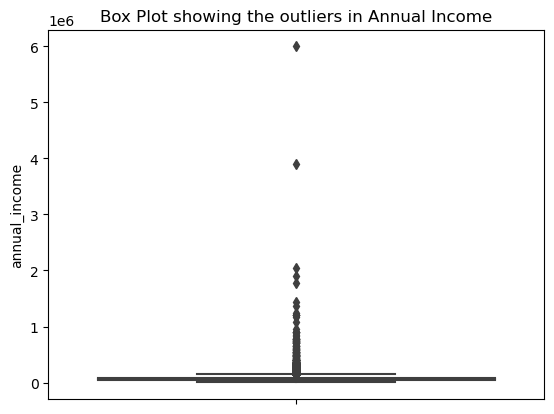

In [18]:
# The data shows that the annual_income series has a very big range of data and may contain outliers.
sns.boxplot(data=loan, y='annual_income')
plt.title('Box Plot showing the outliers in Annual Income')
plt.show()

In [19]:
# Filter out the outliers of data.
loan = loan[loan.annual_income<150000]

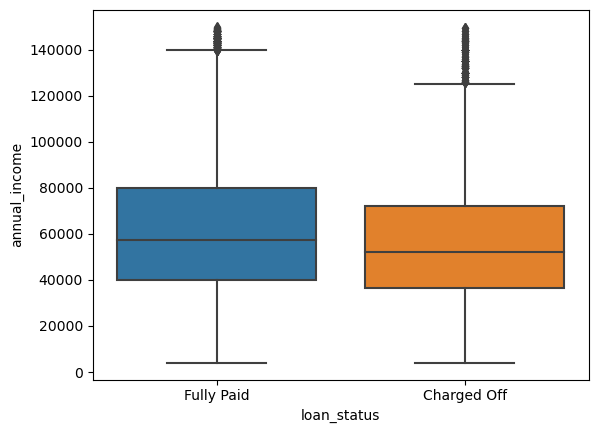

In [20]:
sns.boxplot(data=loan, y='annual_income' , x='loan_status')
plt.show()

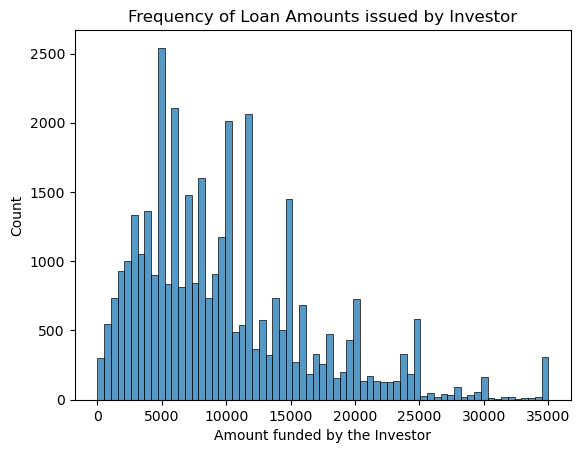

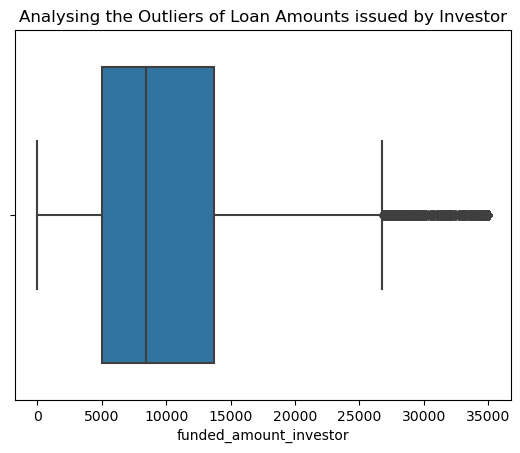

In [21]:
# Analysing the Funded Amount Investor data
plt.title('Frequency of Loan Amounts issued by Investor')
plt.xlabel('Amount funded by the Investor')
sns.histplot(data=loan, x='funded_amount_investor')
plt.show()

# Analyzing the outliers
plt.title('Analysis of Loan Amounts issued by Investor')
plt.title('Analysing the Outliers of Loan Amounts issued by Investor')
plt.xlabel('Amount funded by the Investor')
sns.boxplot(data=loan, x='funded_amount_investor')
plt.show()

<AxesSubplot:xlabel='Count', ylabel='purpose'>

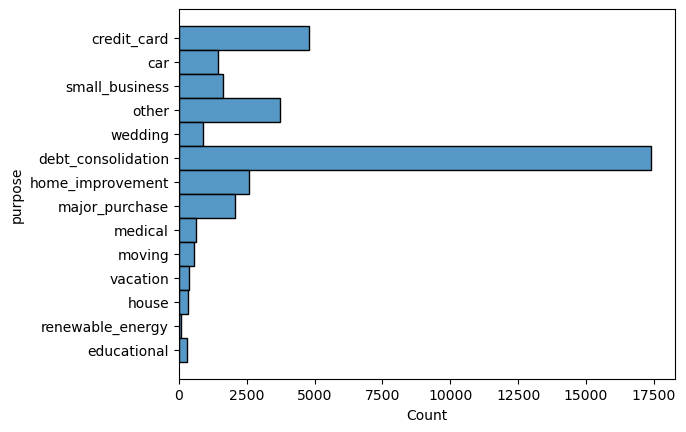

In [22]:
# Analysing the Funded Amount Investor data
sns.histplot(data=loan, y='purpose')


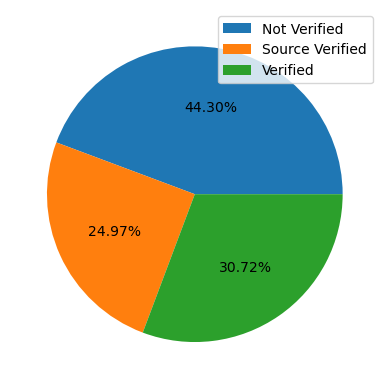

In [23]:
# Let's try analyzing the outliers
data = loan.groupby(by='verification_status').agg({'id':'count'})
plt.pie(data=data, x='id', autopct="%0.2f%%")
plt.legend(data.index)
plt.show()

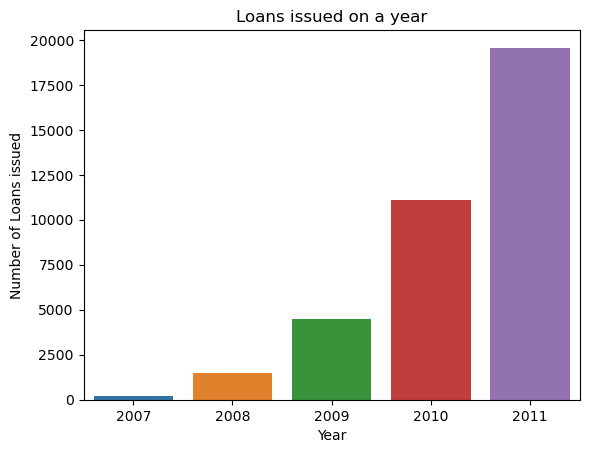

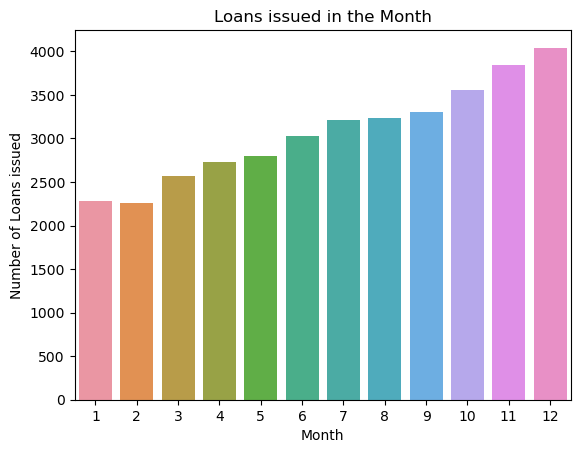

In [24]:
#'loan_status', 'purpose', 'zip_code', 'issue_year', 'issue_month'

sns.countplot(data=loan, x='issue_year')
plt.xlabel('Year')
plt.ylabel('Number of Loans issued')
plt.title('Loans issued on a year')
plt.show()

sns.countplot(data=loan, x='issue_month')
plt.xlabel('Month')
plt.ylabel('Number of Loans issued')
plt.title('Loans issued in the Month')
plt.show()

##### Observations
- We observe that most loans funded are < 15000.
- Also, there is a significant amount of loans issued at the multiples of 5000 (say: 5000, 10000, ...)
- We observe that most of the loans are in the range of 5000-14000. However, there seems to be good number of outliers as well. 
- We observe that most of the loans are taken in the view of debt consolidation. 
- We observe that almost 43% of the loans issued are not verified.
- We observe that most of the loans are issued on the Month of December.
- We observe that there is a consistent YOY increase in the number of loans issued.
- We observe that most of the loans are issued for the state CA.
- We observe that most of the loans are issued with dti ~ 12.5-15;
- We observe that most of the Charged Off loans have an annual income in the range of 26K ~ 54K.
- We observe that the Charged Off % is more in the state of NE.


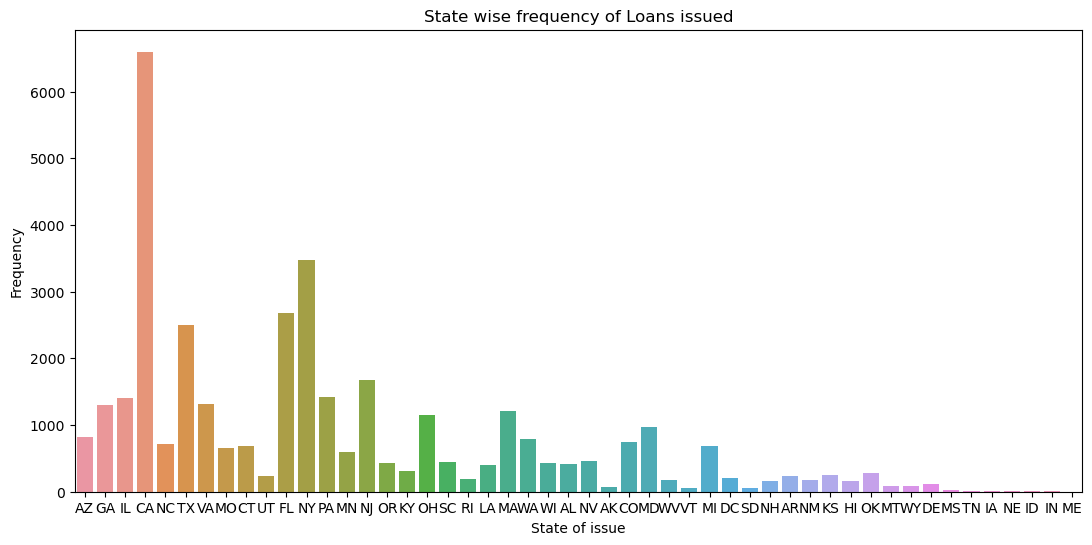

In [25]:
loan.addr_state.value_counts()
plt.figure(figsize=(13,6))
sns.countplot(data=loan, x='addr_state')
plt.title('State wise frequency of Loans issued')
plt.xlabel('State of issue')
plt.ylabel('Frequency')
plt.show()

<AxesSubplot:xlabel='purpose'>

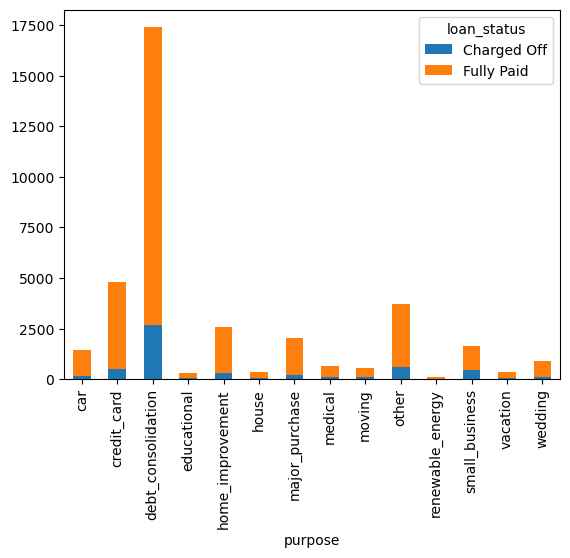

In [26]:
# Check the annual income across groups
#sns.boxplot(loan.annual_income)
#loan[loan.annual_income <=100000]
#sns.histplot(data=loan, x='annual_income', binrange=np.arange(0,70000, 50000))
loan_status_pivot_data = pd.pivot_table(data=loan, columns='loan_status', index='purpose', values='id', aggfunc='count')
loan_status_pivot_data.plot(kind='bar', stacked=True)

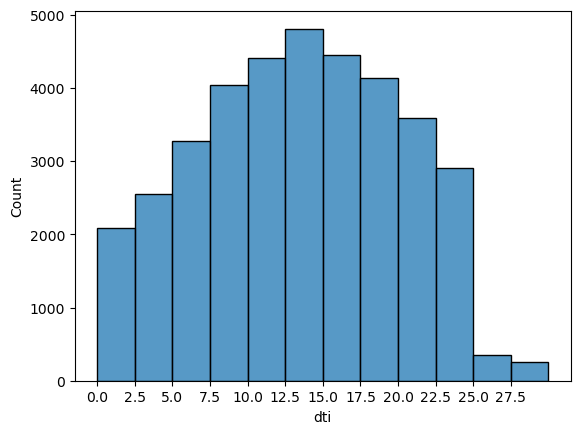

In [28]:
### loan.dti.value_counts()
bins_range = np.arange(0.0, 30.0, 2.5)

sns.histplot(data=loan, x='dti', bins=12)
plt.xticks(bins_range)
plt.show()

In [45]:
charged_off_loans = loan[loan.loan_status == 'Charged Off']
fully_paid_loans = loan[loan.loan_status == 'Fully Paid']

In [54]:
charged_off_loans.annual_income.describe()

count      5438.000000
mean      56767.650811
std       27070.341165
min        4080.000000
25%       36404.210000
50%       52000.000000
75%       72000.000000
max      149616.000000
Name: annual_income, dtype: float64

In [78]:
charged_off_loans.annual_income.describe()

count      5438.000000
mean      56767.650811
std       27070.341165
min        4080.000000
25%       36404.210000
50%       52000.000000
75%       72000.000000
max      149616.000000
Name: annual_income, dtype: float64

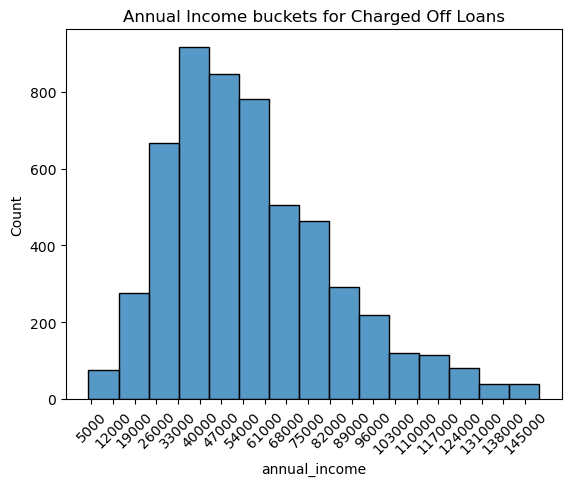

In [77]:
#Check for various annual_income values for Charged Off loans and see which income bucket is likely to impact. 
sns.histplot(data=charged_off_loans, x='annual_income', bins=15)
plt.xticks(ticks=np.arange(5000.0, 150000.0, 7000), rotation=45)
plt.title('Annual Income buckets for Charged Off Loans')
plt.show()

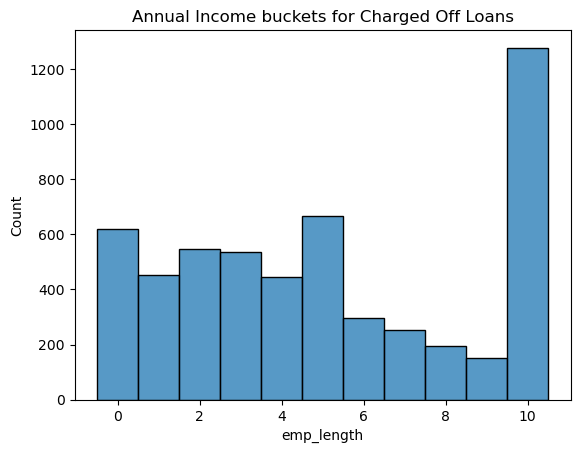

In [100]:
#Check for various annual_income values for Charged Off loans and see which income bucket is likely to impact. 
sns.histplot(data=charged_off_loans, x='emp_length', bins=10)
plt.title('Annual Income buckets for Charged Off Loans')
plt.show()

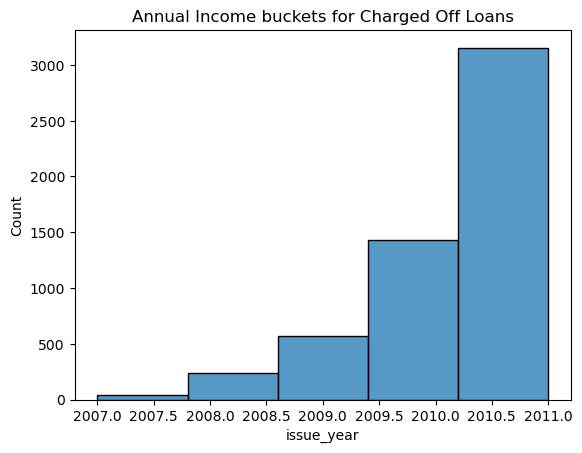

In [103]:
#Check for various annual_income values for Charged Off loans and see which income bucket is likely to impact. 
sns.histplot(data=charged_off_loans, x='issue_year', bins=5)
plt.title('Annual Income buckets for Charged Off Loans')
plt.show()

In [128]:
#loan.groupby(by=['addr_state', 'loan_status']).agg({'annual_income': 'count'}).plot(kind='bar')


state_wise_loan_data = loan.pivot_table(index='addr_state', columns='loan_status', values='id', aggfunc='count', fill_value=0.00)
state_wise_loan_data['charged_off_percentage'] = round(state_wise_loan_data['Charged Off'] * 100 / (state_wise_loan_data['Charged Off'] +  state_wise_loan_data['Fully Paid']), 2)

In [130]:
state_wise_loan_data

loan_status,Charged Off,Fully Paid,charged_off_percentage
addr_state,,,
AK,13,58,18.31
AL,52,371,12.29
AR,26,203,11.35
AZ,118,700,14.43
CA,1079,5519,16.35
CO,96,648,12.90
CT,92,588,13.53
DC,14,186,7.00
DE,12,97,11.01


In [ ]:
loan.groupby(by='addr_state').apply(lambda x: 100* x/float(x.sum()))

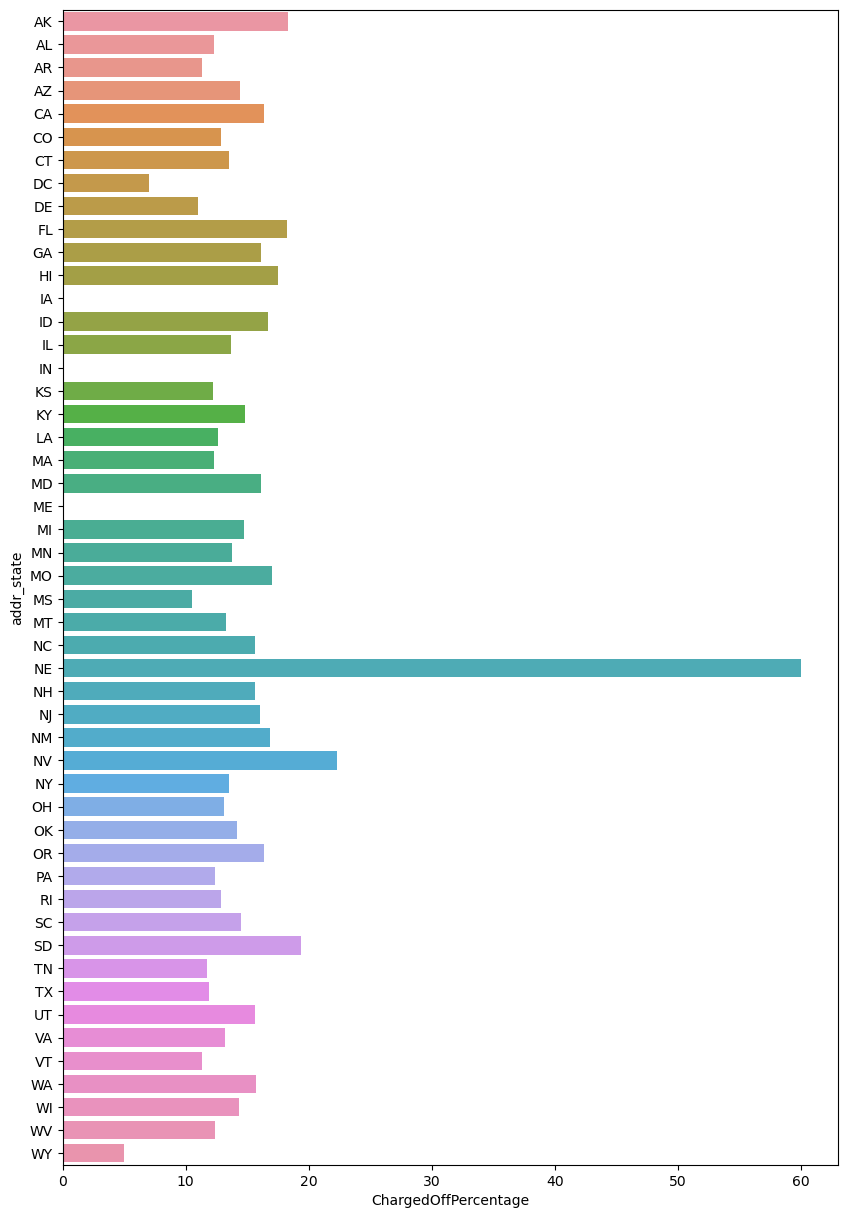

In [166]:
k = loan.pivot_table(columns='loan_status', index='addr_state', values='annual_income', aggfunc='count', fill_value=0)
k['ChargedOffPercentage'] = k['Charged Off'] *100 /(k['Charged Off'] + k['Fully Paid'])

k = k.reset_index()
plt.figure(figsize=(10,15))
sns.barplot(data=k, x='ChargedOffPercentage', y='addr_state')
plt.show()


#### Find the loans defaulted

### Bivariate Analysis

In [29]:
#loan_status vs verification_status
#loan_status vs home_ownership
#loan_status vs employee_length
#loan_status vs annual_income
#loan_status vs purpose
#dti vs state
#dti vs loan_status

SyntaxError: invalid syntax (569818446.py, line 1)

ValueError: could not convert string to float: 'B'

<AxesSubplot:xlabel='verification_status', ylabel='count'>

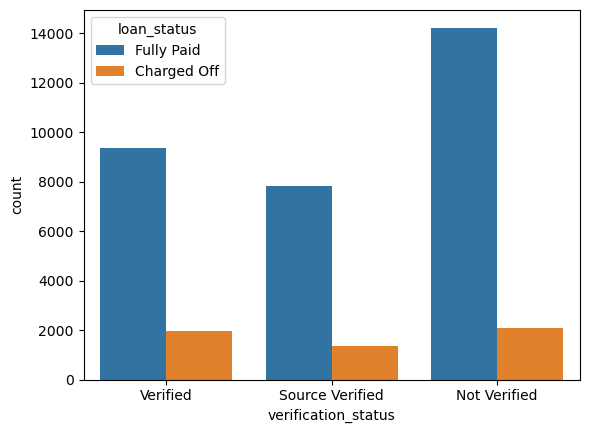

In [37]:
#sns.countplot(data=loan, x='verification_status', hue='loan_status')


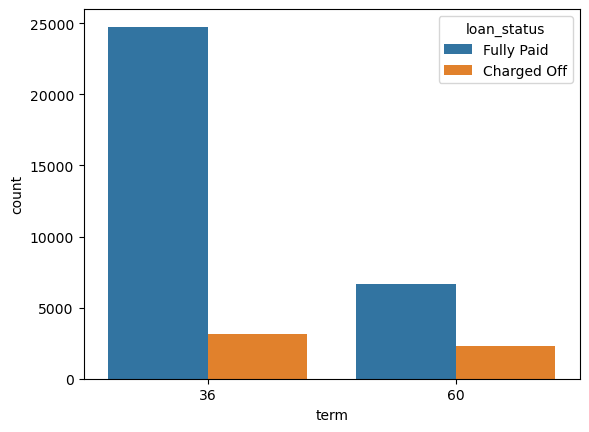

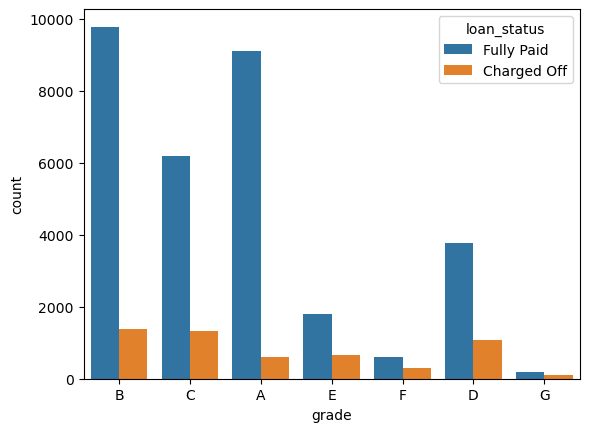

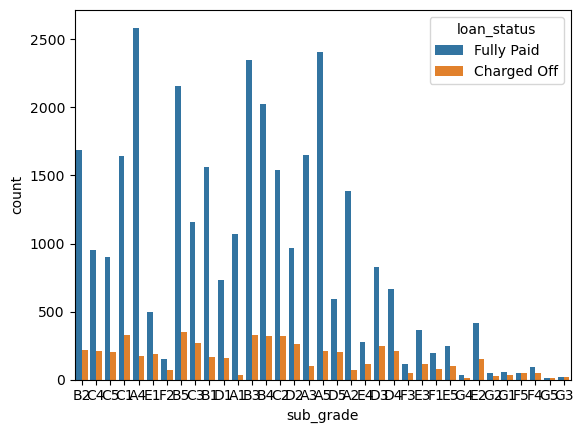

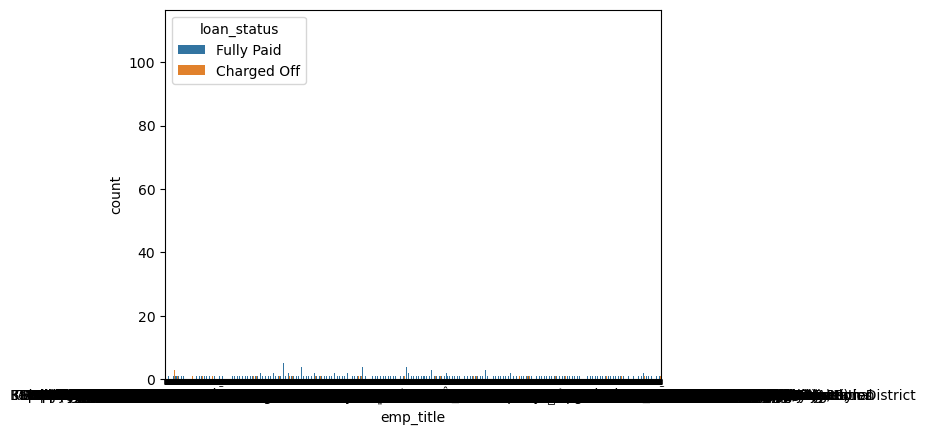

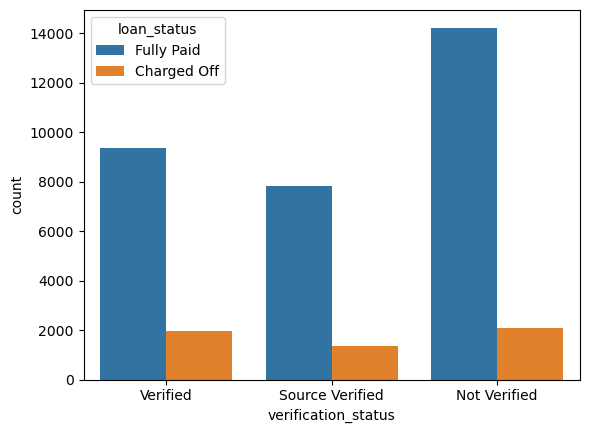

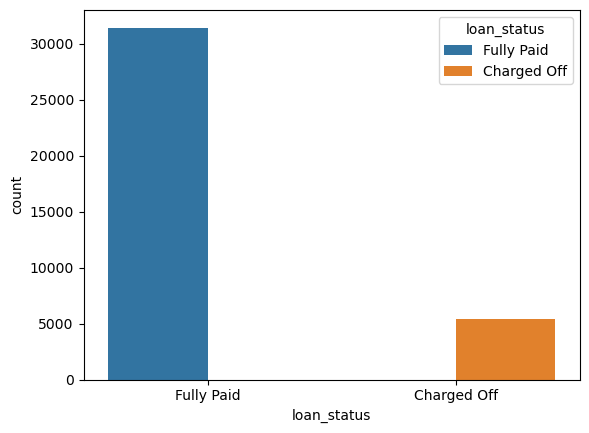

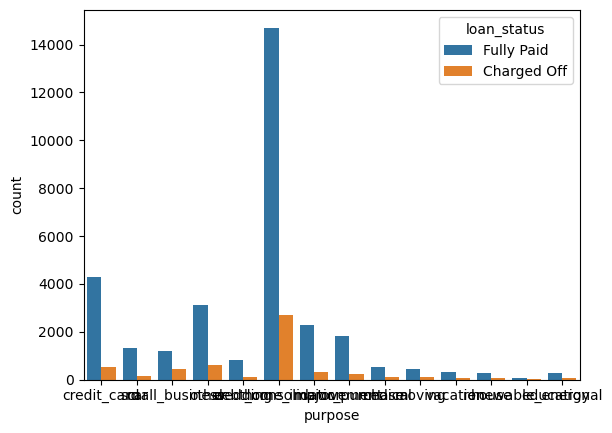

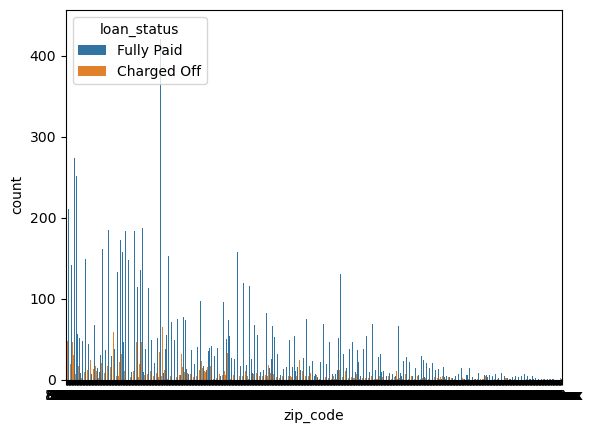

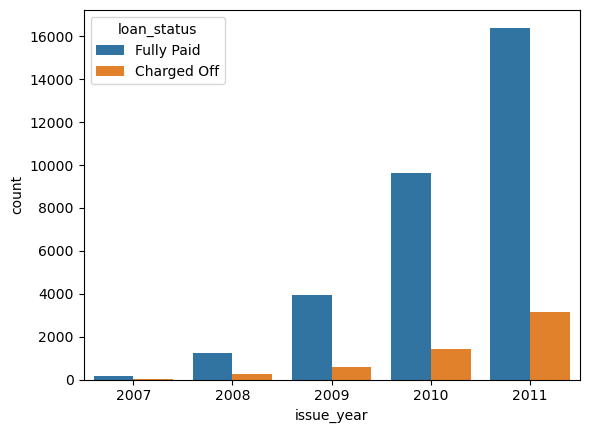

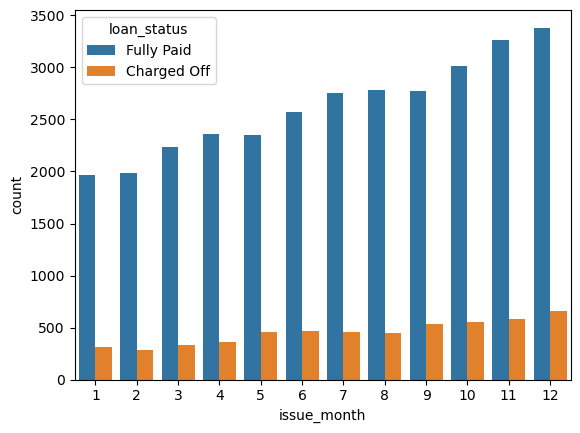

In [43]:
for cat in categorical_columns:
    sns.countplot(data=loan, x=cat, hue='loan_status')
    plt.show()

In [ ]:
for col in loan.columns:
    if(len(loan[col].unique()) > 1) :
        print(col)

In [ ]:
len(loan.application_type.unique())

In [ ]:
loan.groupby(by='id').info()